In [7]:
import sys
import os
from metient.metient import *
from metient.util import data_extraction_util as dutil

REPO_DIR = os.path.join(os.getcwd(), "../../")
TRACERX_DATA_DIR = os.path.join(REPO_DIR, 'data/tracerx_nsclc/')
INPUT_DIR = os.path.join(TRACERX_DATA_DIR, 'tracerx_provided_patient_data', )
OUTPUT_DIR = os.path.join(TRACERX_DATA_DIR, "metient_outputs", "test")

def run_conipher_patient(patient, weights):
    space = "x"*44
    tsv_fn = os.path.join(INPUT_DIR, f"{patient}_SNVs.tsv")
    print(tsv_fn)
    print(f"{space} PATIENT {patient} {space}")
    tree_fn = os.path.join(INPUT_DIR, f"{patient}_tree.txt")
    tree = dutil.get_adjacency_matrix_from_txt_edge_list(tree_fn)
    print_config = PrintConfig(visualize=True, verbose=False, k_best_trees=30)
    evaluate_label_clone_tree(tree, tsv_fn, weights, print_config, OUTPUT_DIR, patient, O=None,
                              solve_polytomies=True, batch_size=3048)
    

/lila/data/morrisq/divyak/projects/metient/metient/jupyter_notebooks/tracerx_analysis/../../data/tracerx_nsclc/tracerx_provided_patient_data/CRUK0290_SNVs.tsv
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx PATIENT CRUK0290 xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
/lila/data/morrisq/divyak/projects/metient/metient/jupyter_notebooks/tracerx_analysis/../../data/tracerx_nsclc/tracerx_provided_patient_data/CRUK0290_SNVs.tsv
ordered_sites ['LN_SU_LN1', 'primary_SU_T1', 'LN_SU_FLN1']
nodes_w_polys [0, 1, 2, 7, 10] resolver_sites [[2], [0], [0], [1], [2]]
poly_res.children_of_polys [1, 2, 19, 7, 10, 20, 9, 21, 22, 6, 12, 13, 27, 11, 30, 31]
poly_res.resolver_indices [14, 15, 16, 17, 18]
poly_res.resolver_index_to_parent_idx {14: 0, 15: 1, 16: 2, 17: 7, 18: 10}
[3, 4, 5, 6, 7, 8, 12, 13, 17, 23, 24, 25, 26, 27, 28, 34, 35]
[9, 16, 21, 29]
known_indices [2, 3, 4, 5, 6, 7, 11, 12, 8]
unknown_indices [0, 1, 9, 10]
run  0
100.0 1.0 1.0
run  1
1.0 100.0 1.0
run  2
1.0 1.0 100.0
run  3
100.0 1.0 1.

<Figure size 640x480 with 0 Axes>

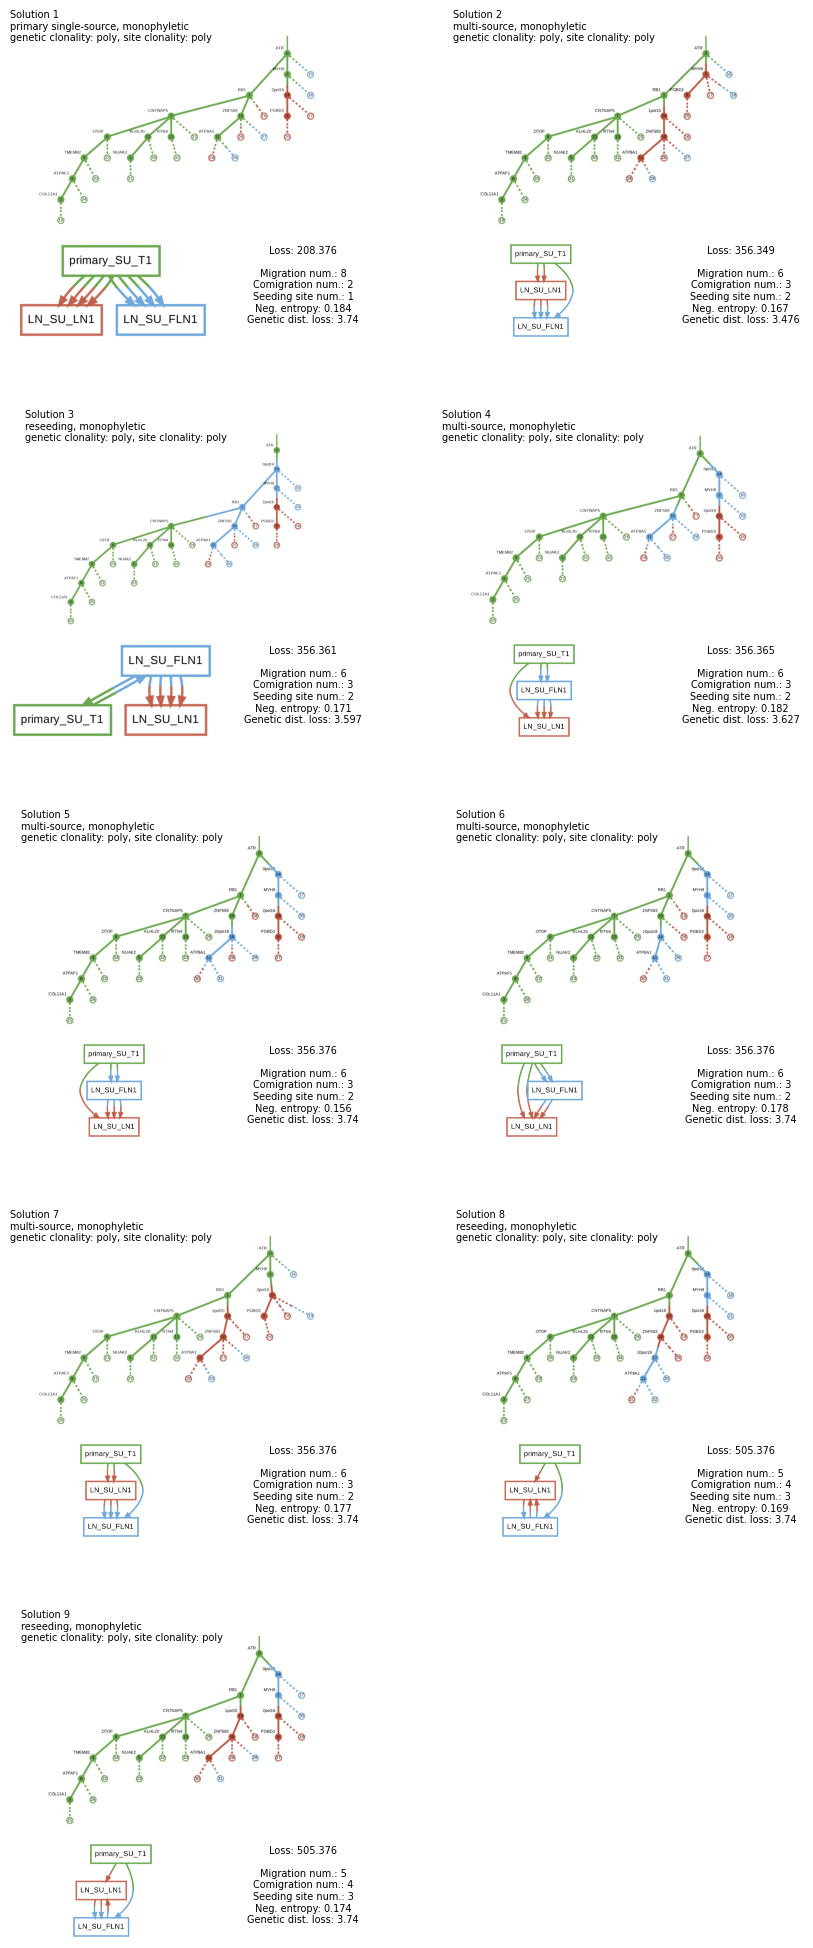

In [10]:
%%prun
weights = Weights(mig=1, comig=50, seed_site=100, reg=2, gen_dist=0.1, organotrop=0.0)

run_conipher_patient("CRUK0290", weights)

In [ ]:

tracerx_reported_counts = {
    "Brain":6, "Chest wall":1, "Bronchus":4,"Pleura":2,"Rib":2,
    "Liver":6,"Flank":1,"Femur":1,"Neck LN":2,"Primary LN":148,
    "Recurrence LN":20,"Scapula":1,"Axillary LN":1,"Recurrence lung":13,
    "Primary surgery satellite lesion lung":3, "Adrenal gland":1,
    "Subphrenic mass":1, "Skin":3, "Paravertebral":1, "Peritoneum":1,
    "Lung":0
}

total = sum([tracerx_reported_counts[key] for key in tracerx_reported_counts])
tracerx_reported_freqs = {key:float(tracerx_reported_counts[key]/total) for key in tracerx_reported_counts}
print(tracerx_reported_freqs)
def get_organotropism_matrix_from_tracerx(unique_sites, tracerx_map):
    mapped_sites = [tracerx_map[site] for site in unique_sites]
    organotrop_arr = np.zeros(len(mapped_sites))
    for i, metastatic_site in enumerate(mapped_sites):
        organotrop_arr[i] = tracerx_reported_freqs[metastatic_site]
    return torch.tensor(organotrop_arr, dtype = torch.float32)


In [ ]:
import pandas as pd
no_cna_dir = os.path.join(TRACERX_DATA_DIR, "CRUK0762_no_cna_testing")
dutil.pool_input_tsv(os.path.join(no_cna_dir, "CRUK0762_SNVs.tsv"), no_cna_dir, f"tmp_CRUK0762")
df = pd.read_csv(os.path.join(no_cna_dir,"tmp_CRUK0762_clustered_SNVs.tsv"),sep="\t")
df['implied F no CNA'] = df.apply(lambda row: row['var']/(0.5*row['ref']+row['var']), axis=1)
df = df[['anatomical_site_label', 'cluster_index', 'implied F no CNA']]
matrix_df = df.pivot(index='cluster_index', columns='anatomical_site_label', values='implied F no CNA')
matrix_df.to_csv(os.path.join(no_cna_dir,"CRUK0762_clustered_SNVs_no_cnas.tsv"), sep="\t")


In [ ]:
df